In [232]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt 
import numpy as np
import plotly.express as px
import pandas as pd
df = px.data.iris()
from vicregaddon import *

device = 'cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [233]:
nd = 64  # dimensions of space we're working in
npoints = 12  # number of points, also batch size

random_points = False 
torch.random.manual_seed(0)
if random_points:
    vecs = 0.5* torch.randn((npoints, nd))
else:   
    # start all in a line going from 1 to -1
    vecs = torch.zeros((npoints, nd))
    for i in range(nd):
        vecs[:,i] = torch.linspace(1.0, -1.0, npoints)
print("vecs.shape =", vecs.shape)


# # supervised learning targets
thetas = 6.28/npoints*torch.arange(npoints).unsqueeze(0)
targets = torch.zeros((npoints, nd))
targets[:,:2] = torch.cat((torch.cos(thetas), torch.sin(thetas))).T
print("targets.shape =", targets.shape)


vecs.shape = torch.Size([12, 64])
targets.shape = torch.Size([12, 64])


In [234]:
def plot_w_labels(ax, v, c='b', with_nums=True, ha='center', va='top', label='', markersize=5): 
    x, y = v[:,0].numpy(), v[:,1].numpy()
    ax.plot(x,y,'o', c=c,label=label, markersize=markersize)
    if with_nums:
        for i, (xi, yi) in enumerate(zip(x, y)):
            ax.text(xi, yi-0.05, str(i), ha=ha, va=va, c=c)
        
def plot_graph_old(vecs, targets=None, v_hats=None, v_hats_t=None, legend=False, with_nums=True):
    with torch.no_grad():
        fig, ax = plt.subplots(figsize=(3,3))
        plot_w_labels(ax, vecs.cpu(), label='v', with_nums=with_nums)
        if targets is not None: plot_w_labels(ax, targets, c='r', label='targ', with_nums=with_nums)
        if v_hats is not None: plot_w_labels(ax, v_hats,  c='g', label='v_hat', with_nums=with_nums) 
        if v_hats_t is not None: plot_w_labels(ax, v_hats_t,  c='violet', ha='left',va='bottom', label='v_hat_t', with_nums=with_nums)
        ax.set_aspect('equal')
        if legend: ax.legend()                           
        return plt.show()
    

def update_df(data, df=None, label='data'):
    # create a df with columns x, y, z, label.
    # note that any higher dimensions in data are ignored
    if df is None:
        df = pd.DataFrame(columns=['x', 'y', 'z', 'label'])
    for i in range(data.shape[0]):
        df = pd.concat([df, pd.DataFrame([{'x': data[i,0], 'y': data[i,1], 'z': data[i,2], 'label': label, 'class':i+1}])], ignore_index=True)
    return df
    
def plot_graph(vecs, targets=None, v_hats=None, v_hats_t=None, legend=False, with_nums=True, theme='plotly_dark'):
    df = None
    for data, label in [(vecs, 'vecs'),(targets, 'targets'), (v_hats, 'v_hats'), (v_hats_t, 'v_hats_t')]:
        if data is not None:
            df = update_df(data, df=df, label=label)
    if with_nums:
        fig = px.scatter_3d(df, x='x', y='y', z='z',color='label', text='class')
    else:
        fig = px.scatter_3d(df, x='x', y='y', z='z',color='label')
    save_template = fig.layout.template
    fig.layout.template = theme
    fig.update_layout( margin=dict(l=20, r=20, t=20, b=20),)
    fig.show()
    fig.layout.template = save_template # used for wandb
    return fig 

fig = plot_graph(vecs, targets, with_nums=True)

In [235]:
# from dash import Dash, dcc, html
# app = Dash()
# app.layout = html.Div([
#     dcc.Graph(figure=fig)
# ])

# app.run_server(debug=True, use_reloader=False, port=8051)  # Turn off reloader if inside Jupyter...NOTE: does not work in vscode

In [236]:
class Projector(nn.Module):
    """ h(): some kind of learned nonlinear transformation into some new space"""
    def __init__(self, 
                 nd=3,   # number of dims of the space
                 n_hid=32, # number of hidden dims of the network
                 use_bn=False, # use batch norm
                 ):
        super().__init__()
        n_hid = max(n_hid, nd*2) #  * (nd+1)//4 # scale it up
        self.fc1 = nn.Linear(nd, n_hid, bias=True)
        self.fc2 = nn.Linear(n_hid, n_hid, bias=True)
        self.fc3 = nn.Linear(n_hid, nd, bias=True)
        self.bn1 = None
        if use_bn: self.bn1 = nn.BatchNorm1d(n_hid)
        if use_bn: self.bn2 = nn.BatchNorm1d(n_hid)
        if use_bn: self.bn3 = nn.BatchNorm1d(n_hid)
        self.act = nn.GELU()

    def forward(self, y):
        """ y=encodings of given model, z = embeddings, ie points projected into new space"""
        z = self.act ( self.fc1(y) )
        if self.bn1 is not None: z = self.bn1(z)
        z = self.act ( self.fc2(z) )
        if self.bn1 is not None: z = self.bn2(z)
        z = self.fc3(z)
        #x = self.bn3(x)
        #x = torch.tanh(x)
        return z 

proj = Projector(nd=nd).to(device)
optimizer = Adam(proj.parameters(), lr=0.01)

# I. Supervised Learning
We just minimize the difference between the outputs and the targets. Easy. 

In [237]:
max_steps = 4096
n_frames = 10

print_every = max_steps//n_frames # 100
last_printed, print_interval, print_gamma = -1, 1, 1.5

outs_list = []
for step in range(max_steps):
    t = step 
    optimizer.zero_grad()
    v_hats = proj(vecs.to(device))
    loss = F.mse_loss(v_hats, targets.to(device))
    #print("step, last_printed, print_interval, print_gamma = ",step, last_printed, print_interval, print_gamma)
    
    if step == int(last_printed + print_interval):
        print(f"step {step}/{max_steps}: loss = ",loss.item())
        #plot_graph(vecs,targets, v_hats=v_hats)
        outs = {'step':step, 'loss':loss.item(), 'vecs':vecs.detach().cpu(), 'targets':targets.detach().cpu(), 'v_hats':v_hats.detach().cpu()}
        outs_list.append(outs)
        print_interval = print_interval * print_gamma
        last_printed = step
    loss.backward()
    optimizer.step()

step 0/4096: loss =  0.01897181198000908
step 1/4096: loss =  0.014727378264069557
step 3/4096: loss =  0.010783999226987362
step 6/4096: loss =  0.005166805814951658
step 11/4096: loss =  0.0017528068274259567
step 18/4096: loss =  0.0009549757232889533
step 29/4096: loss =  0.00019884627545252442
step 46/4096: loss =  4.2352134187240154e-05
step 71/4096: loss =  0.0002829070435836911
step 109/4096: loss =  5.904828867642209e-06
step 166/4096: loss =  0.0003266753046773374
step 252/4096: loss =  1.6629513766019954e-06
step 381/4096: loss =  1.3964288427814608e-06
step 575/4096: loss =  1.716110546112759e-06
step 866/4096: loss =  3.110507532255724e-05
step 1303/4096: loss =  1.4521587218041532e-05
step 1959/4096: loss =  1.6262496501440182e-05
step 2944/4096: loss =  2.205665805377066e-05


Plot a suggession of frames

n_frames =  18


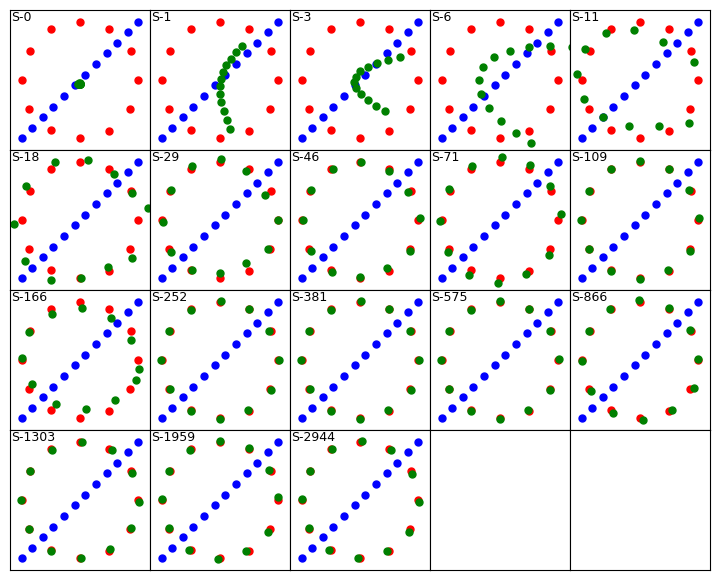

In [238]:
def plot_frames(outs_list, legend=False, ncols=5, with_nums=True):
    n_frames = len(outs_list)
    print("n_frames = ",n_frames)
    nrows = int(round(n_frames/ncols))
    fig_width = 1.4 * ncols
    fig_height = 1.4 * nrows
    fig, axs = plt.subplots(figsize=(fig_width, fig_height), nrows=nrows, 
                            ncols=ncols, sharey=True, sharex=True, gridspec_kw={'hspace': 0})
    # Manually set positions and remove spacing
    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    for i, outs in enumerate(outs_list):
        if i >= len(axs.flatten()): break
        ax = axs.flatten()[i]
        #ax.text(-1.1,0.94,f"S-{outs['step']}", fontsize=9)
        ax.text(0.01, .92, f"S-{outs['step']}", fontsize=9, transform=ax.transAxes)
        plot_w_labels(ax, outs['vecs'], label='v', with_nums=with_nums)
        if 'targets'  in outs.keys(): plot_w_labels(ax, outs['targets'],  c='r', label='targ', with_nums=with_nums)
        if 'v_hats'   in outs.keys(): plot_w_labels(ax, outs['v_hats'],   c='g', label='v_hat', with_nums=with_nums) 
        if 'v_hats_t' in outs.keys(): plot_w_labels(ax, outs['v_hats_t'], c='violet', ha='left',va='bottom', label='v_hat_t', with_nums=with_nums)
        ax.set_aspect('equal')
        # set x and y limits to +/- 1.2
        ax.set_xlim(-1.2,1.2)
        ax.set_ylim(-1.2,1.2)
        if legend: ax.legend() 
    plt.show()
    return fig 

p = plot_frames(outs_list, ncols=5, with_nums=False)

# II. Contrastive Loss
Here we simply enforce that some "operation" holds. For example, that the transform of each point is very close to the transform of the next point. 

## IIa. Explicit affine + rotation operator

In [239]:
# Numpy original from https://github.com/tulip-control/polytope/blob/main/polytope/polytope.py
# Converted to PyTorch by SHH

import torch
import math

def givens_rotation_matrix(i, j, theta, N):
    """Return the Givens rotation matrix for an N-dimensional space."""
    R = torch.eye(N)
    c = torch.cos(theta)
    s = torch.sin(theta)
    R[i, i] = c
    R[j, j] = c
    R[i, j] = -s
    R[j, i] = s
    return R

def solve_rotation_ap(u, v, check_vecs=False, debug=True):
    """Return the rotation matrix for the rotation in the plane defined by the
    vectors u and v across TWICE the angle between u and v.

    This algorithm uses the Aguilera-Perez Algorithm \cite{Aguilera} (https://dspace5.zcu.cz/bitstream/11025/6178/1/N29.pdf)
    to generate the rotation matrix. The algorithm works basically as follows:

    Starting with the Nth component of u, rotate u towards the (N-1)th
    component until the Nth component is zero. Continue until u is parallel to
    the 0th basis vector. Next do the same with v until it only has none zero
    components in the first two dimensions. The result will be something like
    this:

    [[u0,  0, 0 ... 0],
     [v0, v1, 0 ... 0]]

    Now it is trivial to align u with v. Apply the inverse rotations to return
    to the original orientation.

    NOTE: The precision of this method is limited by sin, cos, and arctan
    functions.
    Also NOTE: Reversing order of u,v -> v,u yields R.T
    """
    # BTW: pretty safe to assume u & v have same dims, on same device
    device = u.device
    N = len(u)                       # the number of dimensions
    M = torch.eye(N).to(device)      # stores rotation matrix

    # optional: maybe save a bit of time for (anti-)parallel or zero u & v
    if check_vecs and u.norm() * v.norm() == torch.dot(u,v).abs(): 
        if debug:
            print(f"solve_rotation_ap: zero or (anti-)parallel u,v: 0 degree rotation")
        return M 

    assert len(u.shape)==1, f"u ({list(u.shape)}) & v ({list(v.shape)}) should be single vectors, not batches"
    uv = torch.stack([u, v], axis=1)  # the plane of rotation
    # ensure u has positive basis0 component
    if uv[0, 0] < 0:
        M[0, 0] = -1
        M[1, 1] = -1
        uv = M.matmul(uv)
    # align uv plane with the basis01 plane and u with basis0.
    for c in range(2):
        for r in range(N - 1, c, -1):
            if uv[r, c] != 0:  # skip rotations when theta will be zero
                theta = torch.arctan2(uv[r, c], uv[r - 1, c])
                Mk = givens_rotation_matrix(r, r - 1, theta, N).to(device)
                uv = Mk.matmul(uv)
                M = Mk.matmul(M)
    # rotate u onto v
    theta = 2 * torch.arctan2(uv[1, 1], uv[0, 1])
    if debug:
        print(f"solve_rotation_ap: {180 * theta / math.pi:6.2f} degree rotation")
    R = givens_rotation_matrix(0, 1, theta, N).to(device)
    # perform M rotations in reverse order
    M_inverse = M.T
    R = M_inverse.matmul(R.matmul(M))
    return R


def rotate_batch(R, v_batch):
    #return v_batch @ R  # we could multiply from the right (aka "passive rotations")
    #^But conventionally, ("active") rotations are applied by multiplying from the left, so...
    #return (R @ v_batch.T).T      #  ...but (A @ B).T = B.T @ A.T, so then...
    return v_batch @ R.T   # linear algebra FTW

In [240]:
def get_rot_2d(theta, nd=2):
    c, s = torch.cos(theta), torch.sin(theta)
    return torch.tensor([ [c, -s],[s,c] ])

def get_rot_nd(u, v, debug=False):
    """Return the rotation matrix that rotates u onto v."""
    return solve_rotation_ap(u, v, debug=debug)

class FiLMR2d(nn.Module):
    "affine transformation plus rotation, in 2d"
    def __init__(self, nd=2, 
                 beta_init_fac = 0.0001, # tiny beta for FILM is maybe cheating
                 theta_init_fac=6.28/npoints, # 2pi/n init is "cheating" a bit
                 ):
        super().__init__()
        self.gamma =  nn.Parameter(torch.ones((1)))
        self.beta =  beta_init_fac*nn.Parameter(torch.randn((1)))
        self.theta = theta_init_fac*nn.Parameter( torch.ones((1)) ) 

    def forward(self, x):
        rot = get_rot(self.theta).to(x.device)
        return (x * self.gamma + self.beta.to(x.device)) @ rot


class FiLMRnd(nn.Module):
    "affine transformation plus rotation, in nd"
    def __init__(self, nd=3, 
                 beta_init_fac = 0.0001, # tiny beta is maybe cheating
                 uv_diff_fac = 0.25, # difference scale between initial u and v
                 ):
        super().__init__()
        self.gamma =  nn.Parameter(torch.ones((1)))
        self.beta =  beta_init_fac*nn.Parameter(torch.randn((1)))
        #self.theta = theta_init_fac*nn.Parameter( torch.ones((1)) ) 
        self.u = nn.Parameter( torch.randn((nd)) )
        self.v = nn.Parameter( self.u + uv_diff_fac*torch.randn((nd)) )

    def forward(self, x, debug=False):
        #rot = get_rot(self.theta).to(x.device)
        rot = get_rot_nd(self.u, self.v, debug=debug).to(x.device)
        return (x * self.gamma + self.beta.to(x.device)) @ rot

In [241]:
# and set up for that      

proj2 = Projector(nd=nd).to(device)
trans_op = FiLMRnd(nd=nd).to(device)

optimizer = AdamW( list(proj2.parameters())+list(trans_op.parameters()), lr=1e-3)
#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
#scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1000, T_mult=2)

max_steps = 2**17+1

#scheduler = lr_scheduler.OneCycleLR(optimizer, 2e-3, total_steps=max_steps)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=max_steps)

margin = 6.2/npoints   # spacing beyond which not to push
triplet_criterion = torch.nn.TripletMarginLoss(margin=margin)
margin2 = 1.9
triplet_criterion2 = torch.nn.TripletMarginLoss(margin=margin2)
#distance_func = lambda x,y: ( ((x-y)**2).sum(-1) ) # don't take square root.
#distance_func = lambda x,y: F.pairwise_distance(x,y)**2
#triplet_criterion = torch.nn.TripletMarginWithDistanceLoss(distance_function=distance_func, margin=0.5)


#vicreg_criterion = VICRegLoss(parallel=False, projector=proj2)
def vicreg_var_loss(z:torch.Tensor, gamma=1.0, eps=1e-4):
    "variance loss for VICReg. tries to keep things from collapsing to zero"
    std_z = torch.sqrt(z.var(dim=0) + eps) 
    return torch.mean(F.relu(gamma - std_z))   # the relu performs the max(0, ...)

def vicreg_inv_loss(z1:torch.Tensor, z2:torch.Tensor):
    "invariance / similarity loss for VICReg: just MSE.  Tries to pull like things together"
    return F.mse_loss(z1, z2)

def vicreg_cov_loss(z:torch.Tensor):
    """Covariance loss for VICReg. the sum of the off-diagaonal terms of the covariance matrix. 
    Operates along the batch dimension.  tries to batch data from collapsing to a line"""
    num_features = z.shape[-1]
    cov_z = torch.cov(z.T)#  rearrange(z, 'b n -> ( n ) b'))   
    return off_diagonal(cov_z).pow_(2).sum().div(num_features)

def vicreg_criterion(z1, z2, gamma:float=1., eps:float=1.0e-4,
                     var_weight:float=0.5, inv_weight:float=1.0, cov_weight:float=0.001):
    var_loss = var_weight * 0.5 * ( vicreg_var_loss(z1, gamma=gamma, eps=eps) + vicreg_var_loss(z1, gamma=gamma, eps=eps) ) 
    inv_loss = inv_weight * vicreg_inv_loss(z1, z2)
    cov_loss = cov_weight * 0.5 * ( vicreg_cov_loss(z1) + vicreg_cov_loss(z2) )
    loss =  var_loss + inv_loss + cov_loss 
    return loss, var_loss, inv_loss, cov_loss

In [242]:
z = torch.zeros((npoints, nd))
print("z.shape = ",z.shape)
z[:,0] = torch.arange(npoints)
z[:,1] = torch.arange(npoints)
z[:,2] = torch.arange(npoints)
rolled = torch.roll(z, 1, 0)
var_loss = vicreg_var_loss(z)
inv_loss = vicreg_inv_loss(rolled,z) 
cov_loss = vicreg_cov_loss(z)
print("var_loss, inv_loss, cov_loss = ",var_loss, inv_loss, cov_loss)
print("torch.cov(z.T) = ",torch.cov(z.T))


z.shape =  torch.Size([12, 64])
var_loss, inv_loss, cov_loss =  tensor(0.9436) tensor(0.5156) tensor(15.8438)
torch.cov(z.T) =  tensor([[13., 13., 13.,  ...,  0.,  0.,  0.],
        [13., 13., 13.,  ...,  0.,  0.,  0.],
        [13., 13., 13.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])


Now train...

In [243]:
use_wandb = True
if use_wandb:
    import wandb 
    wandb.init(project='rotnd_vicreg')

In [244]:
outs_list = []
losses, lrs = [], []
outs2_list = []
print_at = [2**n for n in range(14)]
print_at = print_at+ [print_at[-1]*(x+2) for x in range(30)]
#print_at =  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 12000, 16384, 24000, 32768]
print("print_at = ",print_at)
for step in range(max_steps):
    optimizer.zero_grad()
    vecs = vecs.to(device)
    v_hat = proj2(vecs)            # move to a 'circle'
    rolled = torch.roll(v_hat, 1, 0) # location of next one on 'circle'

    v_hat_t = trans_op(v_hat, debug=step in print_at) # transform from one location on circle to new location on 'circle'
    
    #proj_loss =  F.mse_loss(v_hat_t, rolled)  # minimize transformed and next one (contractive)
    #marg_loss =  F.relu( margin - (v_hat - rolled)**2 ).mean()    # keep a minimum distance from the next one though (repulsive)
 
    mag_loss = (v_hat**2 + v_hat_t**2 + rolled**2).mean()/3  # keep things from getting too far out there
    ###mag_loss = -1.5+((0.5/v_hat**2 + v_hat) + (0.5/v_hat_t**2 + v_hat_t) + (0.5/rolled**2 + rolled)).mean()/3  # "celestial loss"
    #mag_loss = mag_loss -1 + 0.1 + (1.0/(v_hat**2+0.1) + 1.0/(v_hat_t**2+0.1) + 1.0/(rolled**2+0.1)).mean()/3  # swinging spring loss

    #vicreg_out = vicreg_criterion({'latent': rolled, 'latent2': v_hat_t})
    #vicreg_loss = vicreg_out['vicreg_loss']
    vicreg_loss, var_loss, inv_loss, cov_loss = vicreg_criterion(rolled, v_hat_t, cov_weight=(0.5 if step < 1000 else 1e-5))
    loss = vicreg_loss

    anchor, pos, neg = rolled, v_hat_t, v_hat    # advance to the next point
    triplet_loss = triplet_criterion(anchor, pos, neg)

    anchor, pos, neg = v_hat_t, rolled, torch.roll(v_hat_t, npoints//2, 0)  # keep point across far away
    triplet_loss2 = triplet_criterion2(anchor, pos, neg) 
    #....not this one: anchor, pos, neg = v_hat_t, rolled, v_hat
    loss = loss + 0.2* 0.5*(triplet_loss + triplet_loss2)
    loss = loss + 0.001*mag_loss 
    close_ends_loss =  ((rolled[0] - v_hat_t[0])**2).mean() 
    loss = loss + close_ends_loss
    
    losses.append(loss.item())
    lr = optimizer.param_groups[0]['lr']
    lrs.append(lr)

    # wandb.log({'loss':loss.item(), 'lr':lr, 'mag_loss':mag_loss.item(), 'vicreg_loss':vicreg_loss.item(), 'close_ends_loss':close_ends_loss.item(),
    #            'var_loss':var_loss.item(), 'inv_loss':inv_loss.item(), 'cov_loss':cov_loss.item(),
    #            'triplet_loss':triplet_loss.item(), 'triplet_loss2':triplet_loss2.item()})
    wandb.log({'lr':lr,}|{x_str:x.item() for x, x_str in zip([loss, mag_loss, vicreg_loss, close_ends_loss, var_loss, inv_loss, cov_loss, triplet_loss, triplet_loss2], 
        ['loss', 'mag_loss', 'vicreg_loss', 'close_ends_loss', 'var_loss', 'inv_loss', 'cov_loss', 'triplet_loss', 'triplet_loss2'])})
    
    #if step % print_every == 0:
    if step in print_at:
        with torch.no_grad():
            print(f"Step {step}/{max_steps}: lr = {lr:.4e}, loss = {loss.item():.4e}")
            #print(f"v_hat[0:1] = {v_hat[0:2,:].numpy()}, v_hat_t[0]={v_hat_t[0].numpy()}")
            fig = plot_graph(vecs.cpu(), targets=rolled.cpu(), v_hats=None, v_hats_t=v_hat_t.cpu(), with_nums=True)
            wandb.log({'plot':fig})
            outs = {'step':step, 'loss':loss.item(), 'vecs':vecs.detach().cpu(), 'targets':rolled.detach().cpu(), 'v_hats_t':v_hat_t.detach().cpu()}
            outs2_list.append(outs)
        
    loss.backward(retain_graph=True) 
    optimizer.step()
    scheduler.step()


print_at =  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 24576, 32768, 40960, 49152, 57344, 65536, 73728, 81920, 90112, 98304, 106496, 114688, 122880, 131072, 139264, 147456, 155648, 163840, 172032, 180224, 188416, 196608, 204800, 212992, 221184, 229376, 237568, 245760, 253952]
solve_rotation_ap:  28.28 degree rotation
Step 1/131073: lr = 1.0000e-03, loss = 6.9308e-01


solve_rotation_ap:  28.21 degree rotation
Step 2/131073: lr = 1.0000e-03, loss = 6.8897e-01


solve_rotation_ap:  28.12 degree rotation
Step 4/131073: lr = 1.0000e-03, loss = 6.7769e-01


solve_rotation_ap:  27.99 degree rotation
Step 8/131073: lr = 1.0000e-03, loss = 6.3790e-01


solve_rotation_ap:  27.96 degree rotation
Step 16/131073: lr = 1.0000e-03, loss = 5.5238e-01


solve_rotation_ap:  28.13 degree rotation
Step 32/131073: lr = 1.0000e-03, loss = 4.9093e-01


solve_rotation_ap:  27.99 degree rotation
Step 64/131073: lr = 1.0000e-03, loss = 4.6716e-01


solve_rotation_ap:  29.85 degree rotation
Step 128/131073: lr = 1.0000e-03, loss = 4.2388e-01


solve_rotation_ap:  29.63 degree rotation
Step 256/131073: lr = 9.9999e-04, loss = 4.2015e-01


solve_rotation_ap:  29.21 degree rotation
Step 512/131073: lr = 9.9996e-04, loss = 4.1883e-01


KeyboardInterrupt: 

In [ ]:
wandb.finish()

close_ends_loss,▂▁▁▁▂█▂▃▂▂▂▂▁▃▁▃▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cov_loss,█▇▃▃▄▃▃▃▃▃▂▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
inv_loss,█▅▅▅█▅▃▄▄▃▂▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▇▅▄▄▆█▃▄▃▃▃▃▃▄▃▄▂▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
mag_loss,█▇▃▃▄▃▃▃▃▃▂▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
triplet_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
triplet_loss2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
var_loss,▁▁█▁▁▁▁▁▁▂▄▁▃▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
vicreg_loss,█▆▅▄▇▄▃▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
close_ends_loss,0.0


In [ ]:
def plot_losses_and_lrs(losses,lrs):
    plt.semilogy(losses)
    plt.ylabel('loss')
    plt.xlabel('step')
    plt.show()

    plt.plot(lrs)
    plt.ylabel('LR')
    plt.xlabel('step')
    plt.show()

In [ ]:

plot_losses_and_lrs(losses,lrs)

n_frames =  29


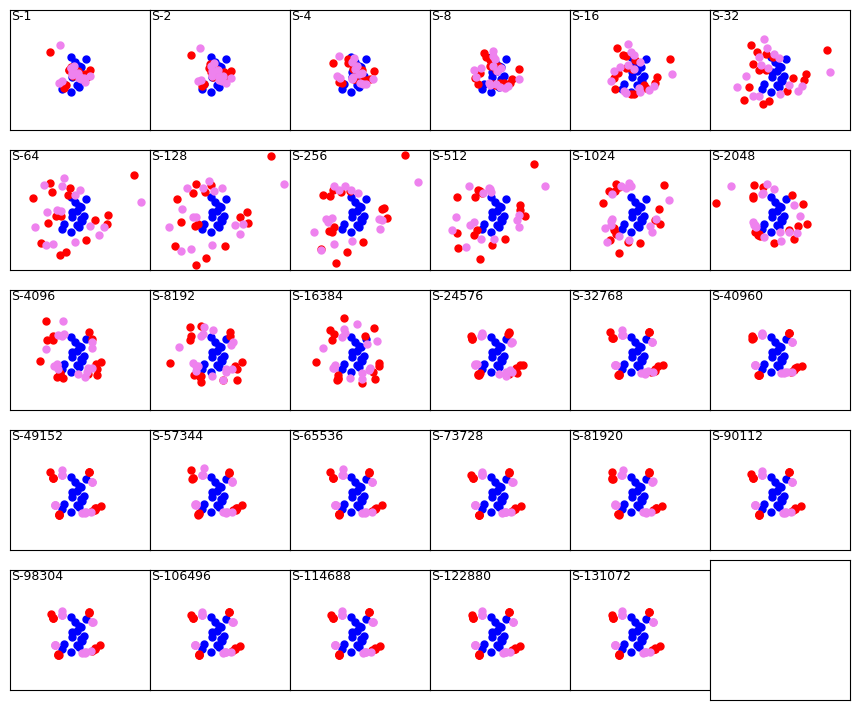

In [ ]:
fig = plot_frames(outs2_list, ncols=6, with_nums=False)

In [ ]:
fig.savefig('FiLMR2d.png')

## IIb. "Just learn a square (/ orthogonal) matrix"
...doesn't seem to learn

print_at =  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
Step 1/40000: lr = 4.000e-05, loss = 9.203e-01


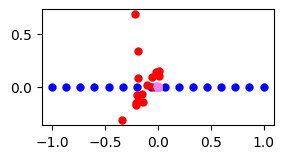

Step 2/40000: lr = 4.000e-05, loss = 9.184e-01


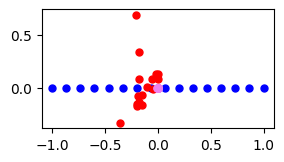

Step 4/40000: lr = 4.000e-05, loss = 9.153e-01


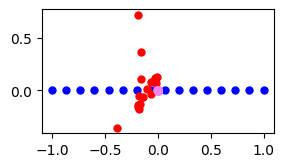

Step 8/40000: lr = 4.000e-05, loss = 9.131e-01


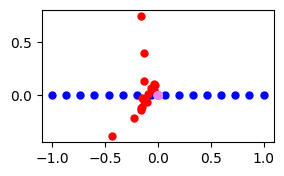

Step 16/40000: lr = 4.000e-05, loss = 9.084e-01


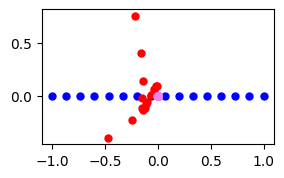

Step 32/40000: lr = 4.002e-05, loss = 8.994e-01


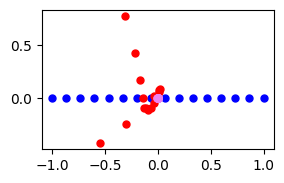

Step 64/40000: lr = 4.007e-05, loss = 8.947e-01


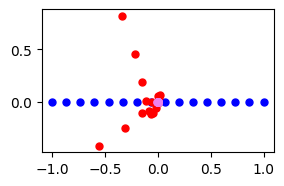

Step 128/40000: lr = 4.027e-05, loss = 8.860e-01


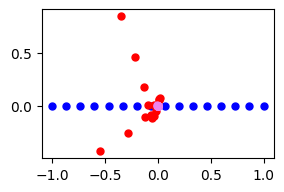

Step 256/40000: lr = 4.108e-05, loss = 8.688e-01


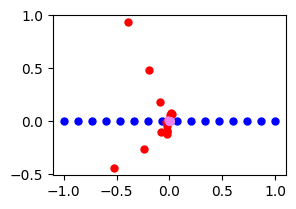

Step 512/40000: lr = 4.431e-05, loss = 8.505e-01


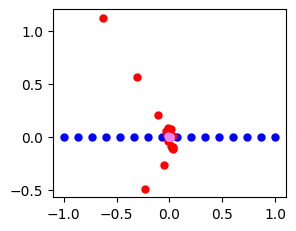

Step 1024/40000: lr = 5.715e-05, loss = 8.289e-01


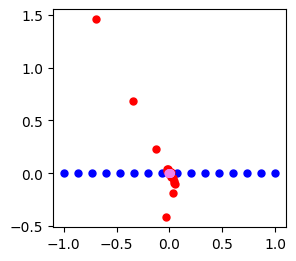

Step 2048/40000: lr = 1.074e-04, loss = 7.694e-01


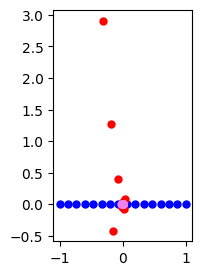

KeyboardInterrupt: 

In [ ]:
class MatOp(nn.Module):
    " just a square matrix operation"
    def __init__(self, nd=2):
        super().__init__()
        self.mat = 0.1*nn.Parameter(torch.randn((nd,nd)))
        #self.mat = nn.Embedding(nd,nd)
        
    def forward(self, x):
        #print("HI!!  self.mat.shape, x.shape = ",self.mat.shape, x.shape)
        x = self.mat.to(x.device).T @ x.T
        x = x.T @ self.mat.to(x.device)
        #return x @ self.mat.weight
        return x
        

proj3 = Projector(nd=nd).to(device)
trans_op2 = MatOp(nd=nd).to(device)

optimizer = AdamW( list(proj3.parameters())+list(trans_op2.parameters()), lr=5e-4)
#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
#scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1000, T_mult=2)

max_steps = 40000
scheduler = lr_scheduler.OneCycleLR(optimizer, 1e-3, total_steps=max_steps)

margin = 6/n
criterion = torch.nn.TripletMarginLoss(margin)


print_every = max_steps/20
print_at = [2**n for n in range(16)]
print("print_at = ",print_at)

losses, lrs = [], []
outs3_list = []
for step in range(max_steps):
    optimizer.zero_grad()
    v_hat = proj3(vecs.to(device))            # move to a 'circle'
    rolled = torch.roll(v_hat, 1, 0) # location of next one on 'circle'

    v_hat_t = trans_op2(v_hat) # transform from one location on circle to new location on 'circle'
    
    mag_loss = (v_hat**2 + v_hat_t**2 + rolled**2).mean()/3.0  # keep things from getting too far out there
    ortho_loss = F.mse_loss(trans_op2.mat.T @ trans_op2.mat, torch.eye(trans_op2.mat.shape[-1]))

    anchor, pos, neg = rolled, v_hat_t, v_hat
    loss = criterion(anchor, pos, neg) + 0.01*mag_loss + ortho_loss
    
    losses.append(loss.item())
    lr = optimizer.param_groups[0]['lr']
    lrs.append(lr)
    
    #if (step+1) % print_every == 0:
    if step in print_at:
        with torch.no_grad():
            print(f"Step {step}/{max_steps}: lr = {lr:.3e}, loss = {loss.item():.3e}")
            plot_graph(vecs.cpu(), targets=rolled.cpu(), v_hats=None, v_hats_t=v_hat_t.cpu(), with_nums=False)
            outs = {'step':step, 'loss':loss.item(), 'vecs':vecs.detach().cpu(), 'targets':rolled.detach().cpu(), 'v_hats_t':v_hat_t.detach().cpu()}
            outs3_list.append(outs)
        
    loss.backward(retain_graph=True) 
    optimizer.step()
    scheduler.step()

Tends to get long & skinny and stay that way. 

TODO: add loss that penalizes linear shapes.  e.g. subtract area of convex hull

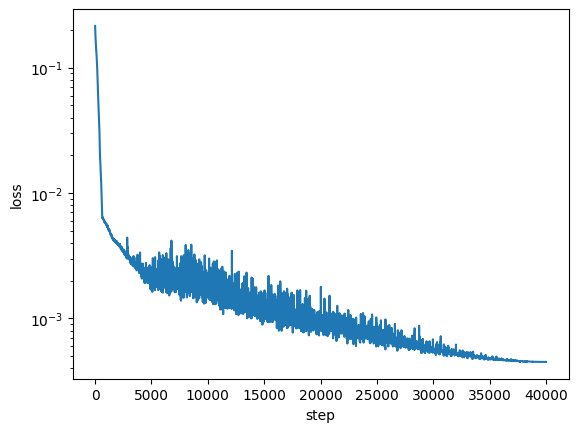

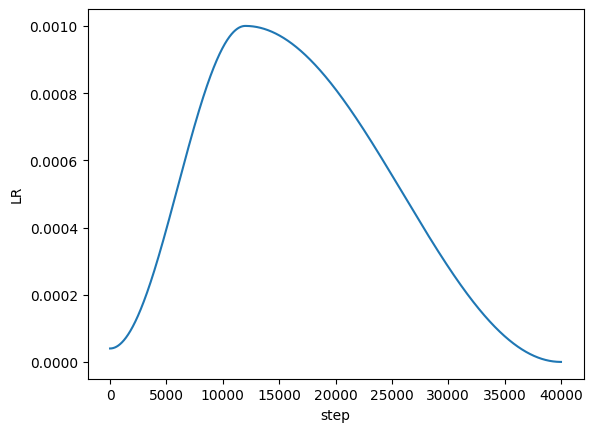

In [ ]:
plot_losses_and_lrs(losses,lrs)

n_frames =  16


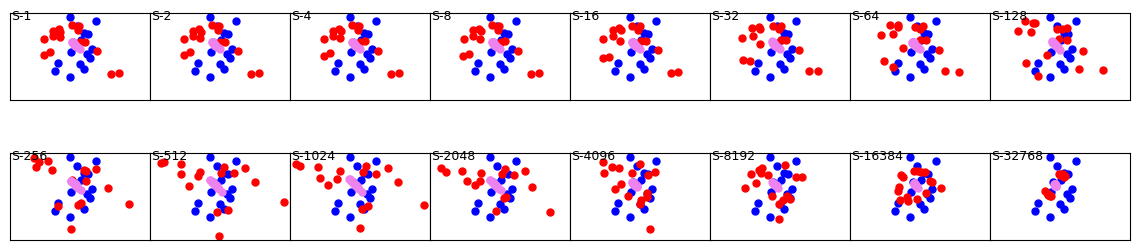

In [ ]:
fig = plot_frames(outs3_list, ncols=8, with_nums=False)

In [ ]:
fig.savefig('MatOp.png')

TODO: try VICReg!